In [36]:
import json
import glob
from collections import defaultdict
import logging
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from collections import Counter

In [37]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# AGGREGATE PORT DATA:

In [38]:
def read_json_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            content = f.read().strip()

            if not content:
                logger.warning(f"Empty file: {file_path}")
                return []

            # Parse as JSON array
            data = json.loads(content)

            if isinstance(data, list):
                return data
            elif isinstance(data, dict):
                return [data]
            else:
                logger.warning(f"Unexpected JSON type in {file_path}: {type(data)}")
                return []

    except json.JSONDecodeError as e:
        logger.error(f"JSON parsing error in {file_path}: {e}")
        return []
    except Exception as e:
        logger.error(f"Error reading {file_path}: {e}")
        return []


def write_aggregated_data(output_path, data_list):
    try:
        os.makedirs(os.path.dirname(output_path), exist_ok=True)

        with open(output_path, 'w', encoding='utf-8') as f:
            json.dump(data_list, f, indent=2, separators=(',', ': '))

    except Exception as e:
        logger.error(f"Error writing to {output_path}: {e}")


def aggregate_data():
    as_directories = glob.glob("AS*")
    as_directories = [d for d in as_directories if os.path.isdir(d)]

    if not as_directories:
        logger.error("No AS directories found in current directory")
        return

    logger.info(f"Found {len(as_directories)} AS directories: {as_directories}")


    port_data = defaultdict(list)

    # each AS directory
    for as_dir in as_directories:
        logger.info(f"Processing directory: {as_dir}")

        # Find all eol_* files in this AS directory
        eol_files = glob.glob(os.path.join(as_dir, "eol_*"))

        for eol_file in eol_files:
            # Extract port number from filename
            filename = os.path.basename(eol_file)
            if not filename.startswith("eol_"):
                continue

            port = filename[4:-5]  # Remove "eol_" prefix and .json endfix??

            logger.info(f"Processing {eol_file} for port {port}")

            # Read JSON array data
            data = read_json_file(eol_file)

            # Add data to port collection
            port_data[port].extend(data)

    # Create output directory
    output_dir = "agg_data"
    os.makedirs(output_dir, exist_ok=True)

    # Write aggregated data for each port
    for port, data_list in port_data.items():
        if not data_list:
            logger.warning(f"No data found for port {port}")
            continue

        output_file = os.path.join(output_dir, f"eol_{port}")

        logger.info(f"Aggregating {len(data_list)} records for port {port}")
        write_aggregated_data(output_file, data_list)

    logger.info(f"Aggregation complete! Output files created in '{output_dir}' directory")
    logger.info(f"Processed {len(port_data)} unique ports: {sorted(port_data.keys())}")


In [39]:
aggregate_data()

INFO - Found 16 AS directories: ['AS20847', 'AS20857', 'AS31477', 'AS41960', 'AS24586', 'AS57043', 'AS15625', 'AS15670', 'AS29063', 'AS197902', 'AS48635', 'AS1101', 'AS39572', 'AS60781', 'AS50673', 'AS15916']
INFO - Processing directory: AS20847
INFO - Processing AS20847/eol_443.json for port 443
INFO - Processing AS20847/eol_995.json for port 995
INFO - Processing AS20847/eol_465.json for port 465
INFO - Processing AS20847/eol_3306.json for port 3306
INFO - Processing AS20847/eol_80.json for port 80
INFO - Processing AS20847/eol_8080.json for port 8080
INFO - Processing AS20847/eol_993.json for port 993
INFO - Processing AS20847/eol_21.json for port 21
INFO - Processing AS20847/eol_587.json for port 587
INFO - Processing directory: AS20857
INFO - Processing AS20857/eol_443.json for port 443
INFO - Processing AS20857/eol_995.json for port 995
INFO - Processing AS20857/eol_6379.json for port 6379
INFO - Processing AS20857/eol_465.json for port 465
INFO - Processing AS20857/eol_5671.json

# PLOTTING:

In [40]:
def load_eol_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)

    df_indiv = pd.DataFrame(data)

    # Convert eol_from to datetime
    df_indiv['eol_from'] = pd.to_datetime(df_indiv['eol_from'], errors='coerce')

    # Calculate days since EOL
    current_date = datetime.now()
    df_indiv['days_since_eol'] = (current_date - df_indiv['eol_from']).dt.days

    # Create risk severity categories
    def categorize_risk(row):
        if not row['is_eol']:
            return 'Current'
        elif pd.isna(row['days_since_eol']):
            return 'EOL (Date Unknown)'
        elif row['days_since_eol'] <= 180:  # 6 months
            return 'EOL 0-6 months'
        elif row['days_since_eol'] <= 365:  # 1 year
            return 'EOL 6-12 months'
        elif row['days_since_eol'] <= 730:  # 2 years
            return 'EOL 1-2 years'
        else:
            return 'EOL 2+ years'

    df_indiv['risk_category'] = df_indiv.apply(categorize_risk, axis=1)

    return df_indiv


def load_all_aggregated_data(agg_data_dir="agg_data"):
    eol_files = glob.glob(os.path.join(agg_data_dir, "eol_*"))

    all_dataframes = []

    for eol_file in eol_files:
        filename = os.path.basename(eol_file)
        port = filename[4:-5] # remove eol_ and .json

        # Load data using the existing function
        df_individual = load_eol_data(eol_file)

        if df_individual.empty:
            logger.warning(f"No data loaded from {eol_file}")
            continue

        df_individual['port'] = port

        all_dataframes.append(df_individual)

    return pd.concat(all_dataframes, ignore_index=True)


In [41]:
df = load_all_aggregated_data("agg_data")
# Display summary statistics
print("\n" + "="*60)
print("AGGREGATED EOL DATA SUMMARY")
print("="*60)

print(f"\nTotal records: {len(df):,}")
print(f"Unique IPs: {df['ip'].nunique():,}")
print(f"Unique servers: {df['server'].nunique()}")
print(f"Ports analyzed: {', '.join(sorted(df['port'].unique()))}")


print("\nServer Distribution (Top 10):")
server_counts = df['server'].value_counts().head(10)
for server, count in server_counts.items():
    percentage = (count / len(df)) * 100
    print(f"  {server}: {count:,} ({percentage:.1f}%)")

print("\nEOL Status:")
eol_counts = df['is_eol'].value_counts()
for status, count in eol_counts.items():
    percentage = (count / len(df)) * 100
    status_label = "EOL" if status else "Current"
    print(f"  {status_label}: {count:,} ({percentage:.1f}%)")

print("\n" + "="*60)



AGGREGATED EOL DATA SUMMARY

Total records: 96,731
Unique IPs: 39,511
Unique servers: 19
Ports analyzed: 

Server Distribution (Top 10):
  Exim: 28,946 (29.9%)
  unknown: 23,431 (24.2%)
  nginx: 21,038 (21.7%)
  Apache: 13,757 (14.2%)
  MariaDB: 3,016 (3.1%)
  OpenSSL: 2,469 (2.6%)
  PHP: 1,891 (2.0%)
  MySQL: 1,259 (1.3%)
  ProFTPD: 378 (0.4%)
  MSSQL: 229 (0.2%)

EOL Status:
  Current: 50,927 (52.6%)
  EOL: 45,804 (47.4%)



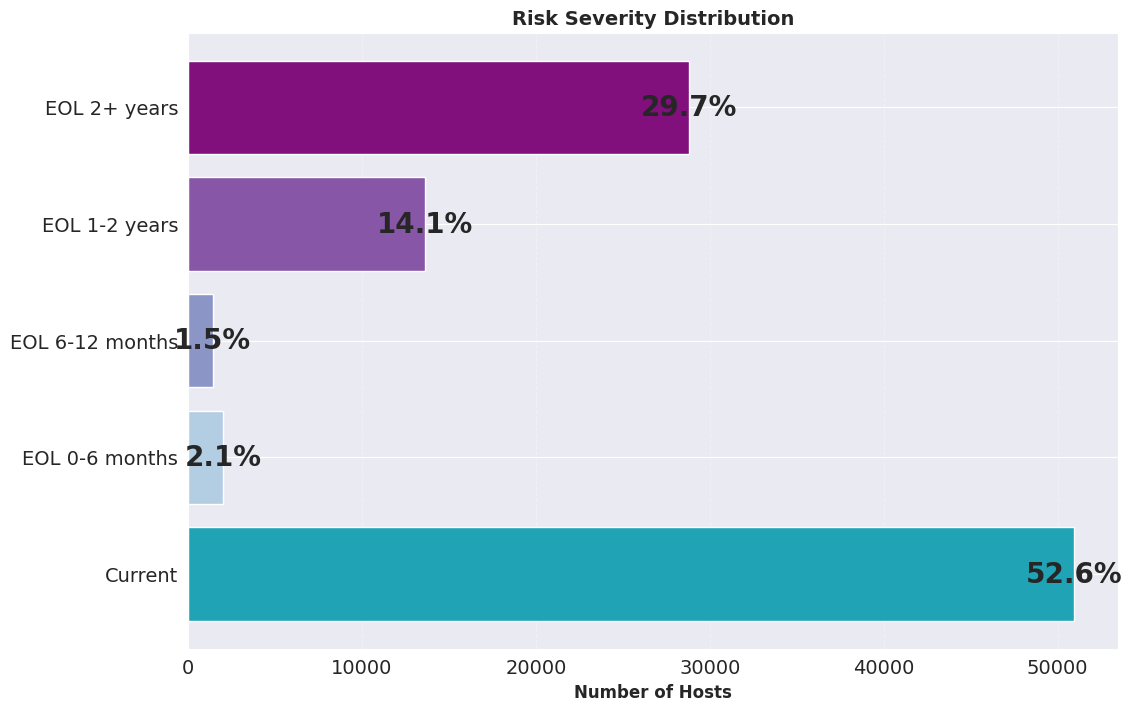

In [42]:
def create_risk_severity_dashboard(df):
    """Create risk severity dashboard with stacked bar chart"""

    # Count by risk category
    risk_counts = df['risk_category'].value_counts()

    # Define risk order and colors
    risk_order = [
        'Current',
        'EOL 0-6 months',
        'EOL 6-12 months',
        'EOL 1-2 years',
        'EOL 2+ years',
    ]

    risk_colors = {
        'Current': '#1fa3b5',
        'EOL 0-6 months': '#b3cde3',
        'EOL 6-12 months': '#8c96c6',
        'EOL 1-2 years': '#8856a7',
        'EOL 2+ years': '#810f7c',
    }

    # Prepare data in correct order
    ordered_counts = []
    ordered_labels = []
    ordered_colors = []

    for category in risk_order:
        if category in risk_counts.index:
            ordered_counts.append(risk_counts[category])
            ordered_labels.append(category)
            ordered_colors.append(risk_colors[category])

    # Create horizontal stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 8))

    # Left plot: Horizontal bar chart
    bars = ax.barh(range(len(ordered_labels)), ordered_counts, color=ordered_colors)
    ax.set_yticks(range(len(ordered_labels)))
    ax.set_yticklabels(ordered_labels)
    ax.set_xlabel('Number of Hosts', fontsize=12, weight='bold')
    ax.set_title('Risk Severity Distribution', fontsize=14, weight='bold')
    ax.grid(axis='x', alpha=0.3, linestyle='--')

    ax.tick_params(axis='y', labelsize=14)
    ax.tick_params(axis='x', labelsize=14)
    total_hosts = len(df)

    # Add value labels on bars
    for i, (bar, count) in enumerate(zip(bars, ordered_counts)):
        # # Total label on the end of the bar
        # ax.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2,
        #         str(count), va='center', fontsize=20, weight='bold')

        # Percentage label in the center of the bar
        percentage = (count / total_hosts) * 100
        ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2,
                f'{percentage:.1f}%', va='center', ha='center',
                fontsize=20, weight='bold')

    plt.savefig('charts/eol_severity_plot_aggregate.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

create_risk_severity_dashboard(df)

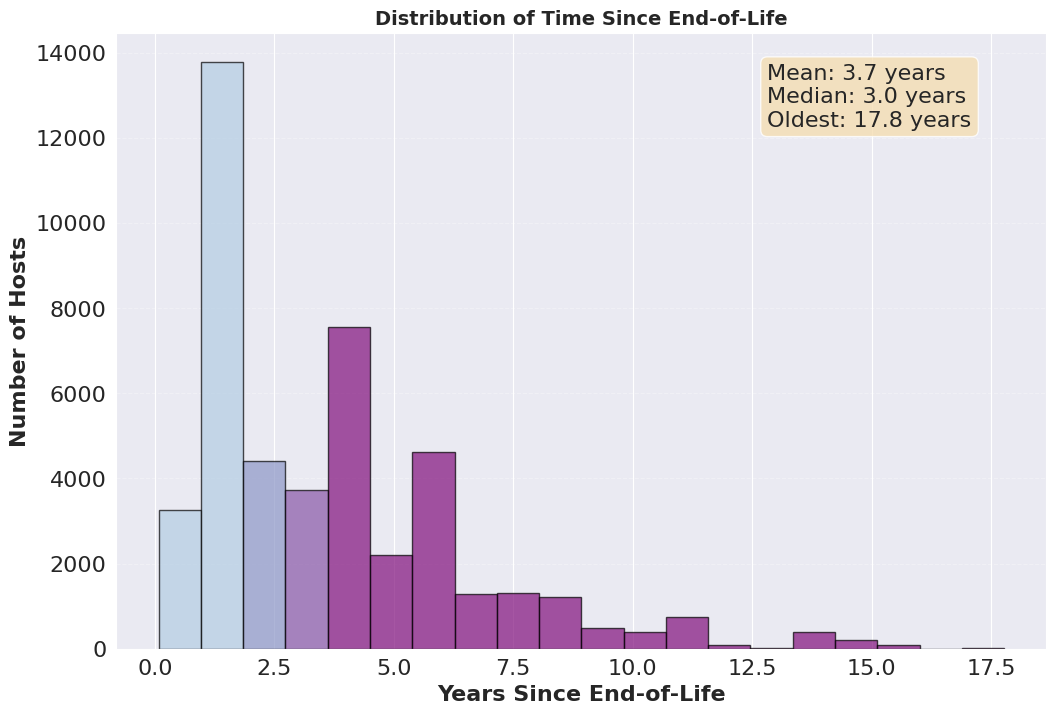

In [43]:
def create_age_distribution_histogram(df):
    """Create age distribution histogram for EOL software"""

    # Filter for EOL software with known dates
    eol_with_dates = df[(df['is_eol'] == True) & (df['days_since_eol'].notna())]

    if len(eol_with_dates) == 0:
        print("No EOL software with known dates found for age distribution.")
        return

    # Convert days to years for better readability
    years_since_eol = eol_with_dates['days_since_eol'] / 365.25

    # Create figure with subplots
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Top plot: Histogram of years since EOL
    n_bins = min(20, len(years_since_eol))
    n, bins, patches = ax1.hist(years_since_eol, bins=n_bins, edgecolor='black', alpha=0.7)

    # Color bars based on age (red for older)
    for i, patch in enumerate(patches):
        if bins[i] < 1:
            patch.set_facecolor('#b3cde3')  # Yellow for < 1 year
        elif bins[i] < 2:
            patch.set_facecolor('#8c96c6')  # Orange for 1-2 years
        elif bins[i] < 3:
            patch.set_facecolor('#8856a7')  # Red for 2-3 years
        else:
            patch.set_facecolor('#810f7c')

    ax1.set_xlabel('Years Since End-of-Life', fontsize=16, weight='bold')
    ax1.set_ylabel('Number of Hosts', fontsize=16, weight='bold')
    ax1.set_title('Distribution of Time Since End-of-Life', fontsize=14, weight='bold')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')


    # Add statistics text
    mean_age = years_since_eol.mean()
    median_age = years_since_eol.median()
    max_age = years_since_eol.max()

    stats_text = f'Mean: {mean_age:.1f} years\nMedian: {median_age:.1f} years\nOldest: {max_age:.1f} years'
    ax1.text(0.7, 0.95, stats_text, transform=ax1.transAxes, fontsize=16,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    ax1.tick_params(axis='y', labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)

    plt.savefig('charts/eol_time_distribution_plot_aggregate.png', dpi=300, bbox_inches='tight', transparent=True)
    plt.show()

create_age_distribution_histogram(df)

# DESTROY AGG_DATA CAUSE GITHUB :

In [44]:
import shutil
import os
if os.path.exists('agg_data'):
    shutil.rmtree('agg_data')